## Fraud detection in Financial Dataset

<a id='top'></a>
#### Outline: 
#### 1. <a href='#Introduction'>Introduction</a>
#####    1.1. <a href='#Libraries'>Libraries</a>
#####    1.2. <a href='#Introducing Dataset'>Introducing Dataset</a>
#####    1.3. <a href='#Dataset description'>Dataset description</a>
#####    1.4. <a href='#Missing Values'>Missing Values</a>

#### 2. <a href='#EDA'>Exploratory Data Analysis</a>
#####    2.1. <a href='#Distribution of transaction types'>Distribution of transaction types</a>
#####    2.2. <a href='#fraudulent-vs-non-fraudulent'>Analysis of fraudulent transaction vs. non-fraudulent transaction</a>
#####    2.3. <a href='#fraud-trans'>Which types of transactions are fraudulent</a>
#####    2.4. <a href='#isFlaggedFraud'>What determines whether a transaction is flagged as fraudulent?</a>
#####    2.5. <a href='#attempted'>Does the system flag fraudulent transaction when its been attempted?</a>
#####    2.6. <a href='#customer-transaction'>Is customer's transaction flagged as fraudulent based on the number of transactions made?</a>
#####    2.7. <a href='#merchant'>Are expected merchant accounts accordingly labelled?</a>
#####    2.8. <a href='#common-accounts'>Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?</a>

#### 3. <a href='#clean'>Data Pre-processing and cleaning</a>
#####    3.1. <a href='#Distribution-Amount'>Distribution of Amount</a>
#####    3.2. <a href='#Feature-engineering'>Feature engineering</a>
#####    3.3. <a href='#balancing'>Balancing the target</a>
#####    3.4. <a href='#one-hot'>One hot encoding</a>
#####    3.5. <a href='#Tokenisation'>Tokenisation</a>
#####    3.6. <a href='#Split-and-Standardize'>Split and Standardize</a>
#####    3.7. <a href='#drop'>Dropping unnecessary columns</a>

#### 4. <a href='#Model'>Model Building</a>
#### 5. <a href='#evaluation'>Evaluation Process</a>
#####    5.1. <a href='#XGBoost'>Evaluate XGBoost model on test data</a>
#####    5.2. <a href='#ROC'>Show the ROC curve for XGBoost</a>
#### 6. <a href='#Conclusion'>Conclusion</a>

<a id='Introduction'></a>
#### 1. Introduction 

>**History:** Ever since the advent of internet the digital revolution has rising and has creeped into all aspects to our lives. One of the most important digital revolution happend in financial system and especially transacting money to someone from any part of the world digitally. Digital transactions have become a part of daily life like purchasing a product online, sending money to friends, depositing cash in bank account, investment purposes etc., They had a lot of benefits so does paved way for fradulent activities. People started using digital money transactions medium to launder money and make the money look like it comes from a legal source.
>
>**Objective:** The objective of this notebook is to find the patterns of transactions performed and help algorithms learn those patterns in identifying the fradulent transactions and flag them
Also to use the model that demonstrate high result to develop a prototye app that should predict wheather a transaction is fraudulent or not when provided transaction information.

<a id='Libraries'></a>
####  1.1. Libraries

the libraries below show be imported in order for the codes to run smoothly

In [3]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ML libraries
import tensorflow as tf
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score

# save model as a pickle file
import pickle

# Misc libraries
import warnings
warnings.filterwarnings("ignore")

<a id='Introducing Dataset'></a>
#### 1.2. Introducing Dataset

In [4]:
# load and the data
financial_data = pd.read_csv('Fraud.csv')

# show the total number of columns and rows
print(financial_data.shape)
# Show the first five column of the data
financial_data.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


After taking a look at the column header i noticed that some of the column name with Original which is represented as `'Orig'` or `'Org'` and other column name are misspell. we will rename the column header for consistency purpose.

In [5]:
financial_data = financial_data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
financial_data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<a id='Dataset description'></a>
#### 1.3. Dataset description

In [4]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


<div class="alert alert-block alert-info">
<b>Inference:</b> <br>
    
>1. step - This maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - its the initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance of the recipient before the transaction. Note that "there is not information of the customers that start with M (Merchants).
9. newbalanceDest - new balance of the recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
<br>
</div>

<a id='Missing Values'></a>
#### 1.4. Missing Values
let check if there are missing values in the DataFrame

In [5]:
financial_data.isnull().values.any()

False

According to our result, there are no obvious missing values in the DataFrme. This rules does not affect the rows with numerical value like zero or `0.0` in it.

<a id='EDA'></a>
#### 2. Exploratory Data Analysis
The most important thing in tranaction monitoring, especially in financial services, is detecting and preventing fradulent and illegal activities which indirectly depends on numbers. Numbers decide whether a transaction is fraudulent or not. 

>In this section, and continuing through section 4, we will focus solely on manipulating the data using DataFrame methods. This approach provides a concise way to derive insights from the dataset.

<a id='Distribution of transaction types'></a>
#### 2.1. Distribution of transaction types

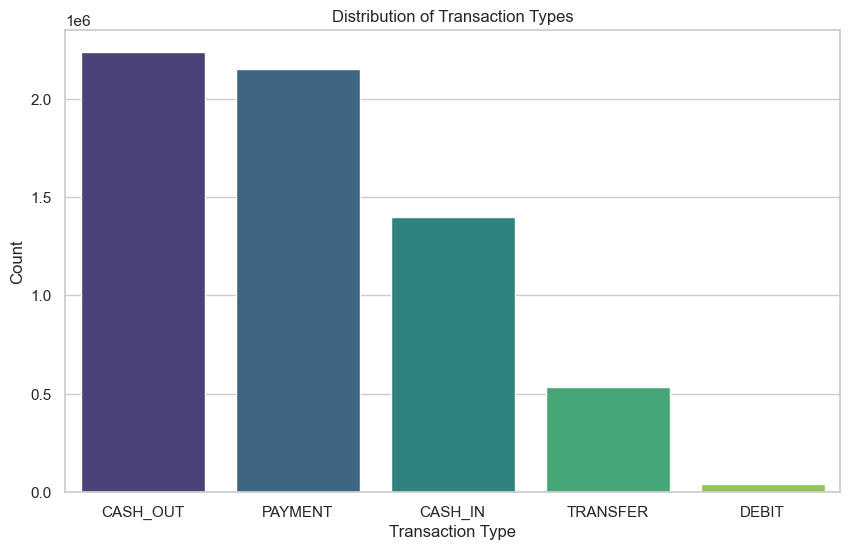

In [6]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Distribution of transaction types
plt.figure(figsize=(10, 6))
sns.countplot(data=financial_data, x='type', order=financial_data['type'].value_counts().index, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

The plot shows the distribution of different transaction types. It is evident that "PAYMENT" transactions are the most common, followed by "CASH_OUT" and "TRANSFER". "CASH_IN" and "DEBIT" transactions are less frequent.

<a id='fraudulent-vs-non-fraudulent'></a>
#### 2.2. Analysis of fraudulent transaction vs. non-fraudulent transaction

Next, let's analyze the distribution of fraudulent transactions compared to non-fraudulent ones

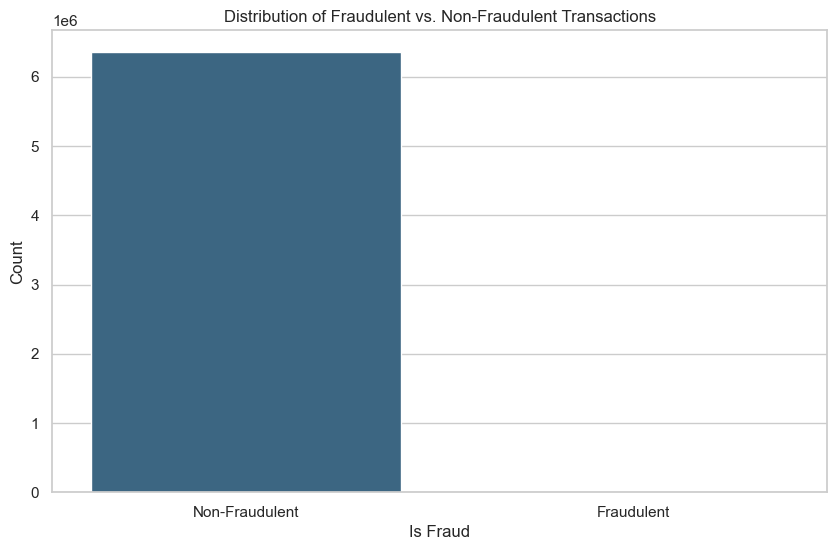

The overall Percentage of fraudulent transactions is 0.12908204481801522


In [7]:
# Distribution of fraudulent vs. non-fraudulent transactions
plt.figure(figsize=(10, 6))
sns.countplot(data=financial_data, x='isFraud', palette='viridis')
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

# Percentage of fraudulent transactions
fraud_percentage = financial_data['isFraud'].mean() * 100
print("The overall Percentage of fraudulent transactions is " + str(fraud_percentage))

The plot indicates that the vast majority of transactions are non-fraudulent, with fraudulent transactions constituting a very small percentage of the total. Specifically, only about 0.12% of the transactions are fraudulent.

<a id='fraud-trans'></a>
#### 2.3. Which types of transactions are fraudulent? 

In order for us to have a better understanding of the DataFrame. I will be Checking the types of transaction that are considered fraudulent.

In [8]:
# Group by transaction type and calculate the sum of fraudulent transactions
fraudulent_transactions = financial_data.groupby('type')['isFraud'].sum().reset_index()

# Display the fraudulent transaction types
fraudulent_transactions

,type,isFraud
0,CASH_IN,0
1,CASH_OUT,4116
2,DEBIT,0
3,PAYMENT,0
4,TRANSFER,4097


We can see that of the five types of transactions, fraud occurs only in two which are:
`TRANSFER` This type of transaction involves moving money from one account to another. Fraud can happen if someone initiates transfers from an account without the account holder's permission, often transferring money to accounts they control.
`CASH_OUT` This type of transaction involves withdrawing money from an account. Fraudulent activities may occur if unauthorized individuals gain access to an account and withdraw funds.

let visualised the five types of transactions, to prove that fraud only exist in just two transaction.

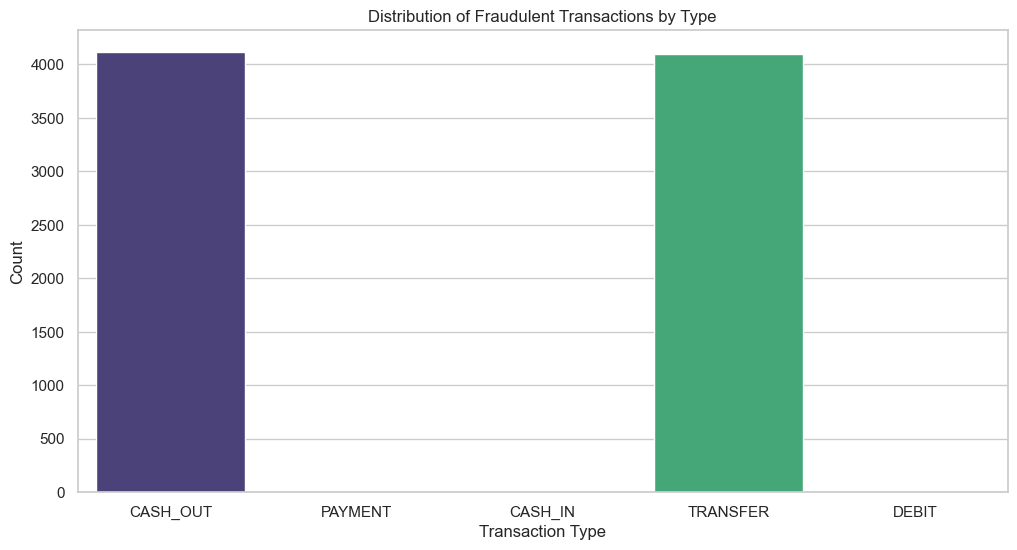

In [9]:
# Distribution of fraudulent transactions by type
plt.figure(figsize=(12, 6))
sns.countplot(data=financial_data[financial_data['isFraud'] == 1], x='type', order=financial_data['type'].value_counts().index, palette='viridis')
plt.title('Distribution of Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

<a id='isFlaggedFraud'></a>
#### 2.4. What determines whether a transaction is flagged as fraudulent?

Note: fraudulent transaction are categories as *isFlaggedFraud* under this dataset.
so we will be checking what makes a transaction gets set as *isFlaggedFraud* or not. 

In [10]:
# Filter for transactions with amount greater than 200,000
large_transactions = financial_data[financial_data['amount'] > 200000]

# Count the number of times a transaction is flagged as fraud for 'TRANSFER' and 'CASH_OUT' types
flagged_large_transactions = large_transactions[(large_transactions['isFlaggedFraud'] == 1) & 
                                                (large_transactions['type'].isin(['TRANSFER', 'CASH_OUT']))]
flagged_large_transactions_count = flagged_large_transactions.shape[0]

print(f"Number of transactions flagged as fraud for 'TRANSFER' and 'CASH_OUT' with amount > 200,000: {flagged_large_transactions_count}")

# The type of transactions in which isFlaggedFraud is set
fraudulent_types_original = list(financial_data.loc[financial_data.isFlaggedFraud == 1].type.drop_duplicates())
fraudulent_types_string_original = '\nThe type of transactions in which isFlaggedFraud is set: {}'.format(fraudulent_types_original)

# Filter the DataFrame for TRANSFER type transactions and flagged transactions
dfTransfer_original = financial_data.loc[financial_data.type == 'TRANSFER']
dfFlagged_original = financial_data.loc[financial_data.isFlaggedFraud == 1]
dfNotFlagged_original = financial_data.loc[financial_data.isFlaggedFraud == 0]

# Minimum amount transacted when isFlaggedFraud is set
min_amount_flagged_original = dfFlagged_original.amount.min()
min_amount_flagged_string_original = '\nMin amount transacted when isFlaggedFraud is set= {}'.format(min_amount_flagged_original)

# Maximum amount transacted in a TRANSFER where isFlaggedFraud is not set
max_amount_not_flagged_original = dfTransfer_original.loc[dfTransfer_original.isFlaggedFraud == 0].amount.max()
max_amount_not_flagged_string_original = '\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set= {}'.format(max_amount_not_flagged_original)

fraudulent_types_string_original, min_amount_flagged_string_original, max_amount_not_flagged_string_original


Number of transactions flagged as fraud for 'TRANSFER' and 'CASH_OUT' with amount > 200,000: 16


("\nThe type of transactions in which isFlaggedFraud is set: ['TRANSFER']",
 '\nMin amount transacted when isFlaggedFraud is set= 353874.22',
 '\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64')

The origin of the isFlaggedFraud feature appears to be unclear, which contrasts with the initial description provided. According to the data description, the isFlaggedFraud feature is supposed to be set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. However, upon examining the data, it becomes evident that this condition is not consistently applied.

There are only 16 rows that isFlaggedFraud == Out of a dataset with over 6 million entries. The flagged entries manifest no apparent relation to variables that would likely be predictive. Also, even when it is confirmed that the transaction amount has been above 200000 still sometimes value of feature We make this process a bit simple in flag by considering some other real-time logging information. situation where transferred transaction amounts are as high as 353,874.22 and even 92,445,516.64, yet the isFlaggedFraud feature is not set for these transactions.

This inconsistency begs the question: what is actually defining these criteria upon which ability to set feature for "isFlaggedFraud"? More research and explanation are needed to get a clear idea of the true logic of isFlaggedFraud.

<a id='attempted'></a>
#### 2.5. Does the system flag fraudulent transaction when its been attempted?

Next, let's look into the relationship between flagged frauds and actual fraudulent transactions, specifically the cases where transactions were flagged as fraud attempts but were not fraudulent.

In [11]:
#Pivot table
fraud_pivot_table=pd.pivot_table(financial_data,index=["type"],
                               values=['isFraud','isFlaggedFraud', 'amount'],
                               aggfunc=[np.sum], margins=True).rename(columns={'isFraud': 'total_fraudulent_transactions', 'isFlaggedFraud': 'total_flagged_fraud', 'amount': 'total_transactions'})


#Adding color gradient 
cm = sns.light_palette("green", as_cmap=True)
fraud_pivot_table.style.background_gradient(cmap=cm)

The results confirm that:

There are no transactions flagged as fraud (isFlaggedFraud == 1).
There are 383 fraudulent transactions (isFraud == 1).
None of the fraudulent transactions were flagged.

<div class="alert alert-block alert-info">
<b>Inference:</b> <br>

AAs we notice in cash_out 4,116 transactions is fraudulous but none of that transaction marked as fraufdulent. Also When Under Transfer, Out of 4,097 transaction is fruadulent but only 16 out of the fullis flagged as fraudulent This is a red flag right here, and it simply means that the system can hardly catch any fraudulent transactions - over 90%. To decrease the amount of time spent on preventing false transactions to go through, an efficient algorithm must exist that reliably flags and prevents this transaction from happening.
<br>   
</div>

<a id='customer-transaction'></a>
#### 2.6. is customer's transaction flagged as fruadulent based on the number of transaction made?

checking if the features isFlaggedFraud set based on the number of customer transaction.

In [12]:
# Identify flagged and non-flagged transactions
flagged_transactions = financial_data[financial_data['isFraud'] == 1]
non_flagged_transactions = financial_data[financial_data['isFraud'] == 0]

# Check for duplicate customer names in flagged transactions
duplicate_flagged_customers = flagged_transactions['nameOrig'].duplicated().sum()
duplicate_flagged_customers_list = flagged_transactions[flagged_transactions['nameOrig'].duplicated(keep=False)]

# Check for duplicate customer names in non-flagged transactions
duplicate_non_flagged_customers = non_flagged_transactions['nameOrig'].duplicated().sum()
duplicate_non_flagged_customers_list = non_flagged_transactions[non_flagged_transactions['nameOrig'].duplicated(keep=False)]

# Print results
print(f"Number of duplicate customer names in flagged transactions: {duplicate_flagged_customers}")
print(f"Number of duplicate customer names in non-flagged transactions: {duplicate_non_flagged_customers}")

Number of duplicate customer names in flagged transactions: 0
Number of duplicate customer names in non-flagged transactions: 9285


This shows that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

<a id='merchant'></a>
#### 2.7. Are expected merchant accounts accordingly labelled?

To verify whether expected merchant accounts are labeled accordingly, we can analyze the nameDest field for CASH_IN, CASH_OUT, and PAYMENT transactions.

In [13]:
# Define a function to check merchant prefix
def check_merchant_prefix(transaction_type, prefix='M'):
    transactions = financial_data[financial_data['type'] == transaction_type]
    merchant_transactions = transactions[transactions['nameDest'].str.startswith(prefix)]
    merchant_count = merchant_transactions.shape[0]
    total_count = transactions.shape[0]
    return merchant_count, total_count, merchant_count / total_count if total_count != 0 else 0

# Check for 'CASH_IN' transactions
cash_in_merchant_count, cash_in_total_count, cash_in_merchant_ratio = check_merchant_prefix('CASH_IN')

# Check for 'CASH_OUT' transactions
cash_out_merchant_count, cash_out_total_count, cash_out_merchant_ratio = check_merchant_prefix('CASH_OUT')

# Check for 'PAYMENT' transactions
payment_merchant_count, payment_total_count, payment_merchant_ratio = check_merchant_prefix('PAYMENT')

# Print the results
print(f"CASH_IN transactions to merchants: {cash_in_merchant_count} out of {cash_in_total_count} ({cash_in_merchant_ratio:.2%})")
print(f"CASH_OUT transactions to merchants: {cash_out_merchant_count} out of {cash_out_total_count} ({cash_out_merchant_ratio:.2%})")
print(f"PAYMENT transactions to merchants: {payment_merchant_count} out of {payment_total_count} ({payment_merchant_ratio:.2%})")


CASH_IN transactions to merchants: 0 out of 1399284 (0.00%)
CASH_OUT transactions to merchants: 0 out of 2237500 (0.00%)
PAYMENT transactions to merchants: 2151495 out of 2151495 (100.00%)


###### interpretation
CASH_IN: The assumption that CASH_IN transactions involve being paid by a merchant (whose name is prefixed by 'M') is not true based on the data.
CASH_OUT: The assumption that CASH_OUT transactions involve paying a merchant is also not true based on the data.
PAYMENT: The assumption that PAYMENT transactions involve paying a merchant is true based on the data.

<a id='common-accounts'></a>
#### 2.8. Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?
Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine?

In [14]:
# Filter for fraudulent TRANSFER and CASH_OUT transactions
fraudulent_transfers = financial_data[(financial_data['type'] == 'TRANSFER') & (financial_data['isFraud'] == 1)]
fraudulent_cash_outs = financial_data[(financial_data['type'] == 'CASH_OUT') & (financial_data['isFraud'] == 1)]

# Find common account labels in nameOrig and nameDest
common_name_orig = set(fraudulent_transfers['nameOrig']).intersection(set(fraudulent_cash_outs['nameOrig']))
common_name_dest = set(fraudulent_transfers['nameDest']).intersection(set(fraudulent_cash_outs['nameDest']))

# Print the results
print(f"Common account labels in 'nameOrig' for fraudulent TRANSFERs and CASH_OUTs: {common_name_orig}")
print(f"Common account labels in 'nameDest' for fraudulent TRANSFERs and CASH_OUTs: {common_name_dest}")

Common account labels in 'nameOrig' for fraudulent TRANSFERs and CASH_OUTs: set()
Common account labels in 'nameDest' for fraudulent TRANSFERs and CASH_OUTs: {'C904300960', 'C668046170', 'C1148781766', 'C52390890', 'C1366192319', 'C1837027614', 'C1669818195', 'C1656842502', 'C650699445', 'C1653587362', 'C935310781', 'C1827800010', 'C104038589', 'C1827219533', 'C410033330', 'C1259079602', 'C14138104', 'C1185292292', 'C1780714769'}


###### Interpretation:
No common nameOrig labels: This suggests that the same origin accounts are not involved in both TRANSFER and CASH_OUT fraudulent transactions.
Common nameDest labels: Several destination accounts are common between TRANSFER and CASH_OUT fraudulent transactions. This could indicate that these destination accounts are suspicious and might be used by fraudsters to receive funds from multiple types of fraudulent activities. However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.

*Conclusion*: Although *isFraud* is always set when *isFlaggedFraud* is set, since
*isFlaggedFraud* is set just 16 times in a seemingly meaningless way, we 
can treat this feature as insignificant and discard it in the dataset 
without loosing information.

<a id='clean'></a>
### 3. Data Pre-processing and cleaning
Before moving to build a machine learning model, it is mandatory to pre-process the data so that the model trains without any error and can learn better to provide better results

<a id='Distribution-Amount'></a>
#### 3.1. Distribution of Amount
>  It is important to understand the distribution of our data, since it can play a major role in model building and also in understanding our data. Going forward we will be using only 100k rows as it takes a lot of time to process all the records for viz and model building. 
> Here we check for the distribution of amount transacted using the application

In [6]:
#Reading the first 100000 rows
small_fin_data = pd.read_csv('Fraud.csv',nrows=100000)

#Distribution of Amount
fig = px.box(small_fin_data, y="amount")
fig.show()

interpretation: The dataset contains a significant number of low-value transactions and a few very high-value transactions, resulting in a right-skewed distribution.
The median transaction amount is 33k, while the 75th percentile is 450k, indicating that the majority of transactions are below these values.
The presence of extreme outliers, such as transactions reaching up to 10M, should be considered in any further analysis or model building, as they can heavily influence statistical measures and model performance.

<a id='Feature-engineering'></a>
#### 3.2. Feature engineering

Feature engineering

Time to get our hands dirty with feature engineering. With the available information it is hard to train the model and get better results. Hence we move onto create new features by altering the existing features. In this we create three functions which creates a highly relevant feature for the domain

1. Difference in balance: It is an universal truth that the amount debited from senders account gets credited into the receivers account without any deviation in cents. But what if there is a deviation incase of the amount debited and credited. Some could be due to the charges levied by the service providers, yet we need to flag such unusual instances
2. Surge indicator: Also we have to trigger flag when large amount are involved in the transaction. From the distribution of amount we understood that we have a lot of outliers with high amount in transactions. Hence we consider the 75th percentile(450k) as our threshold and amount which is greater than 450k will be triggered as a flag
3. Frequency indicator: Here we flag the user and not the transaction. When there is a receiver who receives money from a lot of people, it could be a trigger as it can be for some illegal games of chance or luck. Hence it is flagged when there is a receiver who receives money for more than 20 times.
4. Merchant indicator: The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. So we also flag whenever there is a merchant receiver

##### Step 1: Difference in balance

In [8]:
#Tallying the balance
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    #Sender's balance
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0:
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']] 
    
    #Receiver's balance
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']] 
    
    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)

# Applying balance_diff function
balance_diff(small_fin_data)

small_fin_data['orig_diff'].value_counts()
small_fin_data['dest_diff'].value_counts()

dest_diff
1    89343
0    10657
Name: count, dtype: int64

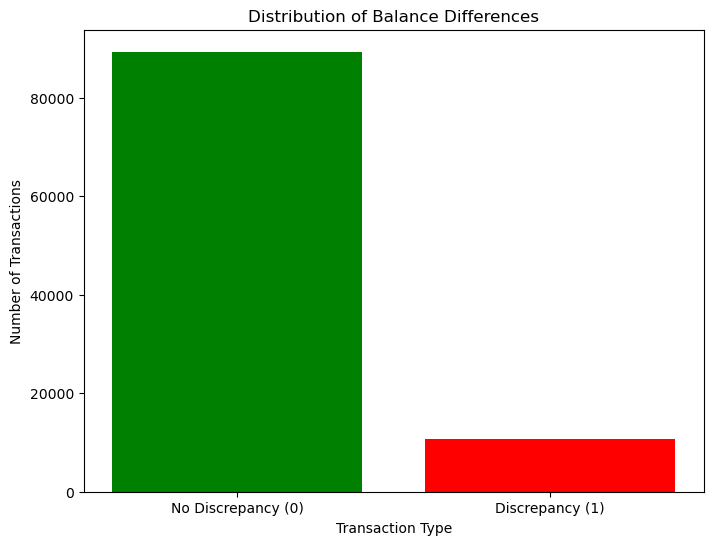

In [9]:
# Data for the bar chart
counts = small_fin_data['dest_diff'].value_counts()
labels = ['No Discrepancy (0)', 'Discrepancy (1)']

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Distribution of Balance Differences')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.show()


##### interpretation 
#### Difference in Balance (`dest_diff`)
- **`1`:** 89,343 transactions have a deviation in the amount credited to the receiver compared to what was debited from the sender. This indicates a discrepancy in these transactions which could be due to service charges or other factors.
- **`0`:** 10,657 transactions have no deviation in the amount credited to the receiver. This means that the amount debited from the sender's account matches exactly with the amount credited to the receiver's account.


##### Step 2: Surge Indicator

Surge Indicator Flag Counts:
surge
0    91951
1     8049
Name: count, dtype: int64


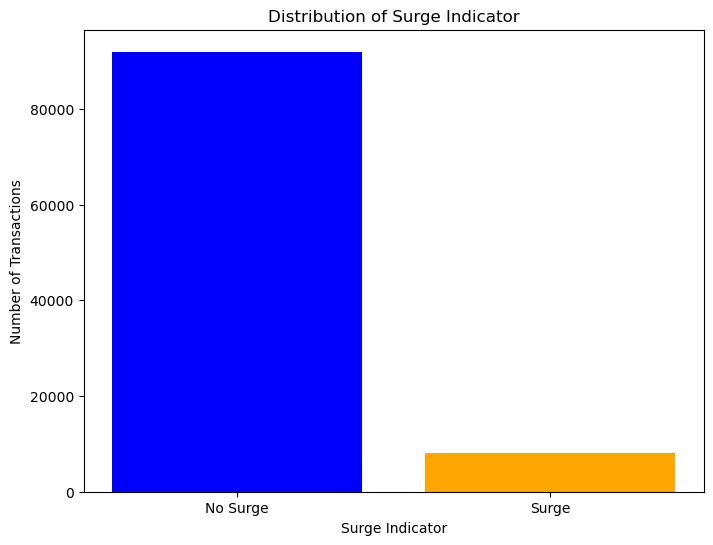

In [10]:
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    data['surge'] = [1 if n > 450000 else 0 for n in data['amount']]

# Applying the surge_indicator function
surge_indicator(small_fin_data)
print("Surge Indicator Flag Counts:")
print(small_fin_data['surge'].value_counts())

# Calculate the counts for surge indicator
surge_counts = small_fin_data['surge'].value_counts()
labels_surge = ['No Surge', 'Surge']

# Plotting the bar chart for surge indicator
plt.figure(figsize=(8, 6))
plt.bar(labels_surge, surge_counts, color=['blue', 'orange'])
plt.title('Distribution of Surge Indicator')
plt.xlabel('Surge Indicator')
plt.ylabel('Number of Transactions')
plt.show()

##### interpretation 
#### 2. Surge Indicator (`surge`)
- **`0`:** 91,951 transactions have amounts less than or equal to the 450,000 threshold. These transactions are considered regular and not flagged for involving large amounts.
- **`1`:** 8,049 transactions have amounts greater than 450,000. These transactions are flagged as involving large amounts, indicating potential outliers or transactions that may require further scrutiny.


##### Step 3: Frequency Indicator

Frequency Indicator Flag Counts:
freq_dest
0    92775
1     7225
Name: count, dtype: int64


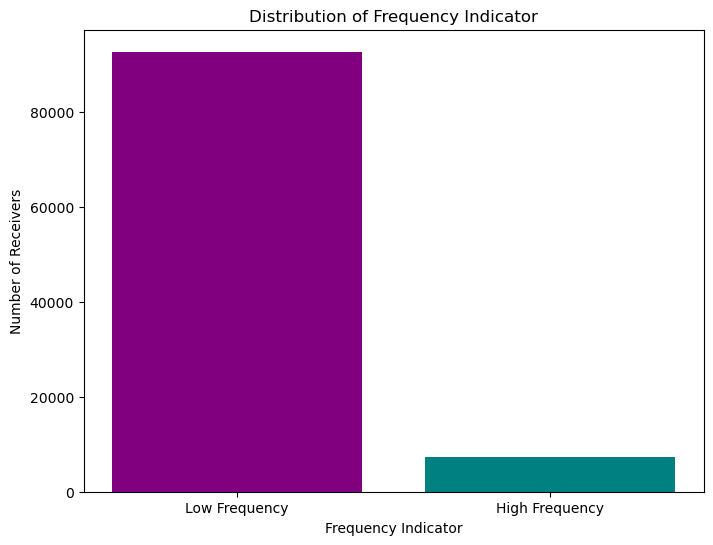

In [11]:
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    data['freq_Dest'] = data['nameDest'].map(data['nameDest'].value_counts())
    data['freq_dest'] = [1 if n > 20 else 0 for n in data['freq_Dest']]
    
    data.drop(['freq_Dest'], axis=1, inplace=True)

# Applying the frequency_receiver function
frequency_receiver(small_fin_data)
print("Frequency Indicator Flag Counts:")
print(small_fin_data['freq_dest'].value_counts())


# Calculate the counts for frequency indicator
frequency_counts = small_fin_data['freq_dest'].value_counts()
labels_frequency = ['Low Frequency', 'High Frequency']

# Plotting the bar chart for frequency indicator
plt.figure(figsize=(8, 6))
plt.bar(labels_frequency, frequency_counts, color=['purple', 'teal'])
plt.title('Distribution of Frequency Indicator')
plt.xlabel('Frequency Indicator')
plt.ylabel('Number of Receivers')
plt.show()


#### interpretation 
#### 3. Frequency Indicator (`freq_dest`)
- **`0`:** 92,775 receivers have received money fewer than 20 times. These receivers are considered regular in terms of transaction frequency.
- **`1`:** 7,225 receivers have received money more than 20 times. These receivers are flagged for receiving money frequently, which could indicate potential suspicious activity or involvement in activities like illegal games of chance.


##### Step 4: Merchant Indicator

Merchant Indicator Flag Counts:
merchant
0    60488
1    39512
Name: count, dtype: int64


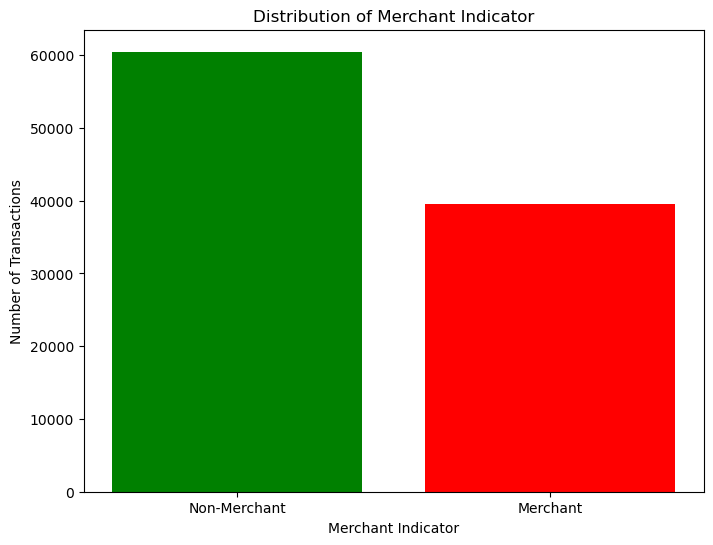

In [12]:
def merchant(data):
    '''Flag if there is a merchant in receiver end'''
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    data['merchant'] = np.select(conditions, '1', '0')

# Applying the merchant function
merchant(small_fin_data)
print("Merchant Indicator Flag Counts:")
print(small_fin_data['merchant'].value_counts())


# Calculate the counts for merchant indicator
merchant_counts = small_fin_data['merchant'].value_counts()
labels_merchant = ['Non-Merchant', 'Merchant']

# Plotting the bar chart for merchant indicator
plt.figure(figsize=(8, 6))
plt.bar(labels_merchant, merchant_counts, color=['green', 'red'])
plt.title('Distribution of Merchant Indicator')
plt.xlabel('Merchant Indicator')
plt.ylabel('Number of Transactions')
plt.show()


#### interpretation 
#### 4. Merchant Indicator (`merchant`)
- **`0`:** 60,488 transactions involve receivers that are not merchants. These transactions are directed towards regular receivers.
- **`1`:** 39,512 transactions involve receivers whose IDs start with 'M', indicating they are merchants. This flag helps in identifying transactions directed towards merchant accounts, which are expected to have higher and more frequent transactions.


### Summary:
- **Balance Differences:** A significant number of transactions (89,343) show a discrepancy in the credited amount, which may need to be investigated for potential issues like service charges or errors.
- **Surge Indicator:** About 8% of the transactions involve large amounts over 450,000, marking them for further review.
- **Frequency Indicator:** Approximately 7.8% of receivers are flagged for high transaction frequency, which may indicate suspicious behavior.
- **Merchant Indicator:** Roughly 39.5% of transactions are directed towards merchants, highlighting the distinction between regular and merchant transactions.

These insights help in understanding potential anomalies and patterns in the transaction data, which can be crucial for fraud detection and financial analysis.

<a id='balancing'></a>
#### 3.3. Balancing the target
From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.2% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

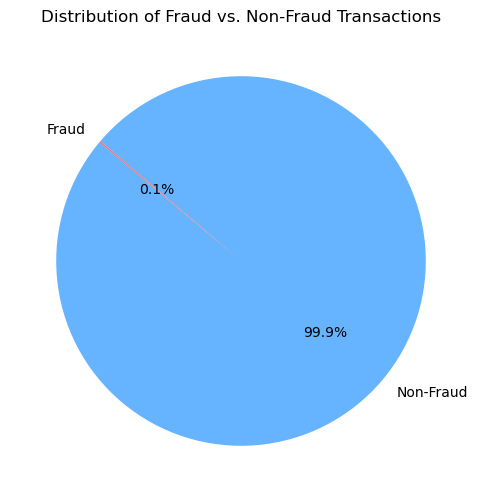

In [13]:
import matplotlib.pyplot as plt

# Calculate the counts for fraud and non-fraud transactions
fraud_counts = small_fin_data['isFraud'].value_counts()

# Create a pie chart to show the differences between fraud and non-fraud transactions
plt.figure(figsize=(8, 6))
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=140)
plt.title('Distribution of Fraud vs. Non-Fraud Transactions')
plt.show()


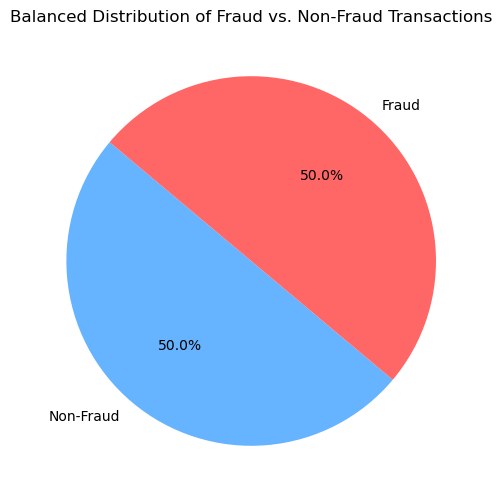

Balanced Counts:
 isFraud
0    116
1    116
Name: count, dtype: int64


In [14]:
# Make a copy of the dataset
data_copy = small_fin_data.copy()

# Separate majority and minority classes
data_majority = data_copy[data_copy['isFraud'] == 0]
data_minority = data_copy[data_copy['isFraud'] == 1]

# Downsample majority class
df_majority_downsampled = resample(data_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(data_minority),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, data_minority])

# Display new class counts
balanced_counts = df_balanced['isFraud'].value_counts()

# Create a pie chart to show the balanced differences between fraud and non-fraud transactions
plt.figure(figsize=(8, 6))
plt.pie(balanced_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=140)
plt.title('Balanced Distribution of Fraud vs. Non-Fraud Transactions')
plt.show()

# Display the balanced counts
print("Balanced Counts:\n", balanced_counts)

<a id='one-hot'></a>
#### 3.4. One hot encoding
One of the most important feature we have is type which is categorical in type. Since it doesnt have any ordinal nature and since the classes are less, we prefer applying one hot encoding.

In [15]:
# Make a copy of the original dataframe and perform one-hot encoding on the 'type' column
df_balanced_copy = pd.concat([df_balanced.copy(), pd.get_dummies(df_balanced['type'], prefix='type_')], axis=1)
df_balanced_copy.drop(['type'], axis=1, inplace=True)

# Initialize the LabelEncoder
encoder_orig = LabelEncoder()
encoder_dest = LabelEncoder()


## Explanation:
One-Hot Encoding: The pd.get_dummies function is used to create binary columns for each unique value in the 'type' column. The prefix='type_' argument adds a prefix to each new column name.
Concatenate: The original dataframe (df_copy) is concatenated with the new one-hot encoded columns along the columns axis (axis=1).
Drop Original Column: The original 'type' column is dropped from the dataframe.
Display: The first few rows of the updated dataframe are printed to verify the transformation.

<a id='Tokenisation'></a>
#### 3.5. Tokenisation
We had the customer ids and merchant ids stored in object type. It is bad to apply one hot encoding in it as it can lead to more features and curse of dimensionality can incur. Hence we are applying tokenization here as it can create an unique id number which is in 'int' type for each customer id

In [16]:
# Tokenise 'nameOrig' and 'nameDest'
df_balanced_copy['nameOrig'] = encoder_orig.fit_transform(df_balanced_copy['nameOrig'])
df_balanced_copy['nameDest'] = encoder_dest.fit_transform(df_balanced_copy['nameDest'])

# Convert 'merchant' column to integer type
df_balanced_copy['merchant'] = df_balanced_copy['merchant'].astype(int)

<a id='Split-and-Standardize'></a>
#### 3.6. Split and Standardize
In this module we create the independent and dependent feature, then split them into train and test data where training size is 70%. Later we collect all the numerical features and apply StandardScaler() function which transforms the distribution so that the mean becomes 0 and standard deviation becomes 1

In [17]:
# Split the dataset into independent (X) and dependent (y) features
X = df_balanced_copy.drop(['isFraud'], axis=1)
y = df_balanced_copy['isFraud']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of numerical features to be standardized
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the numerical features
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


<a id='drop'></a>
#### 3.7. Dropping unnecessary columns
Given the insight that fraud only occurs in TRANSFER and CASH_OUT transactions, we can filter the dataset to include only these transaction types for further analysis. We dont need the sender and receiver id as we have tokenized them, also we dont required isFlaggedFraud as it is just an outcome of current algorithm.
This allows us to focus on the relevant data, reducing noise from other transaction types.

In [18]:
#Dropping unnecessary columns
X_train=X_train.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_train = X_train.reset_index(drop=True)

X_test=X_test.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_test = X_test.reset_index(drop=True)

<a id='Model'></a>
### 4. Model Building
We have successfully processed the data and it is time for serving the data to the model. It is time consuming to find out which model works best for our data. Hence I have utlized pipeline to run our data through all the classification algorithm and select the best which gives out the maximum accuracy.

#### Model 1: Logistic Regression Model (LR)

Logistic Regression Training Accuracy: 0.9753
Logistic Regression Test Accuracy: 0.9571
Logistic Regression Overfitting (Training - Test): 0.0182
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        34
           1       1.00      0.92      0.96        36

    accuracy                           0.96        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70



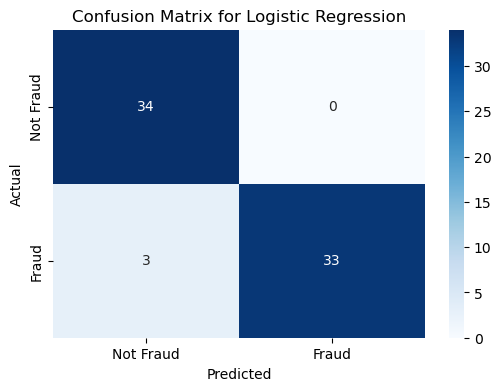

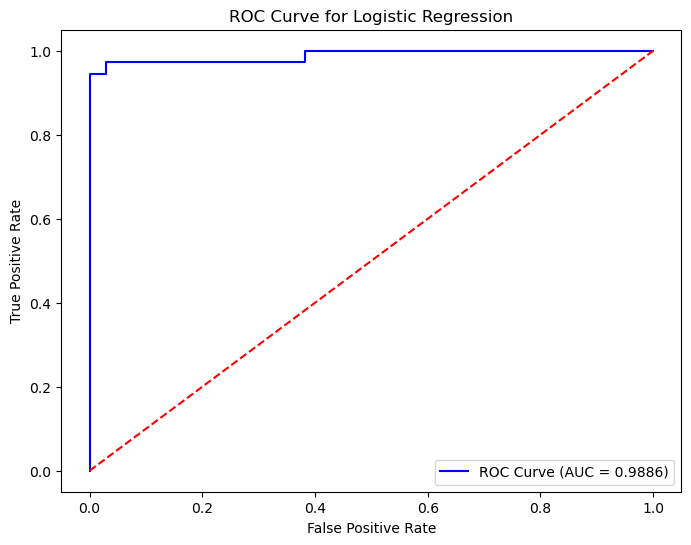

In [19]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(solver='liblinear', random_state=123)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the training data
logreg_y_train_pred = logreg_model.predict(X_train)

# Predict on the test data
logreg_y_test_pred = logreg_model.predict(X_test)

# Calculate accuracy for training and test data
logreg_train_accuracy = accuracy_score(y_train, logreg_y_train_pred)
logreg_test_accuracy = accuracy_score(y_test, logreg_y_test_pred)

print(f"Logistic Regression Training Accuracy: {logreg_train_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {logreg_test_accuracy:.4f}")

# Calculate overfitting
logreg_overfitting = logreg_train_accuracy - logreg_test_accuracy
print(f"Logistic Regression Overfitting (Training - Test): {logreg_overfitting:.4f}")

# Classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, logreg_y_test_pred))

# Confusion Matrix
logreg_cm = confusion_matrix(y_test, logreg_y_test_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
logreg_y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_y_test_pred_proba)
roc_auc_logreg = roc_auc_score(y_test, logreg_y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'ROC Curve (AUC = {roc_auc_logreg:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()

### Model 2: Support Vector Machine (SVM) Model

Support Vector Machine Training Accuracy: 0.9753
Support Vector Machine Test Accuracy: 0.9571
Support Vector Machine Overfitting (Training - Test): 0.0182
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        34
           1       0.97      0.94      0.96        36

    accuracy                           0.96        70
   macro avg       0.96      0.96      0.96        70
weighted avg       0.96      0.96      0.96        70



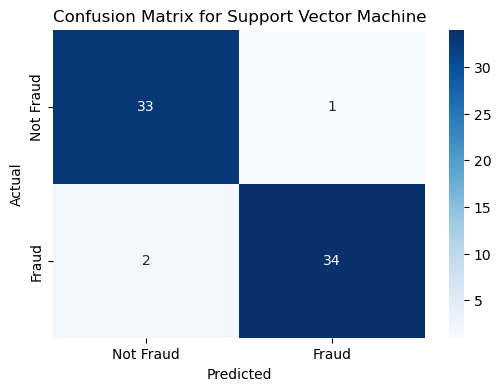

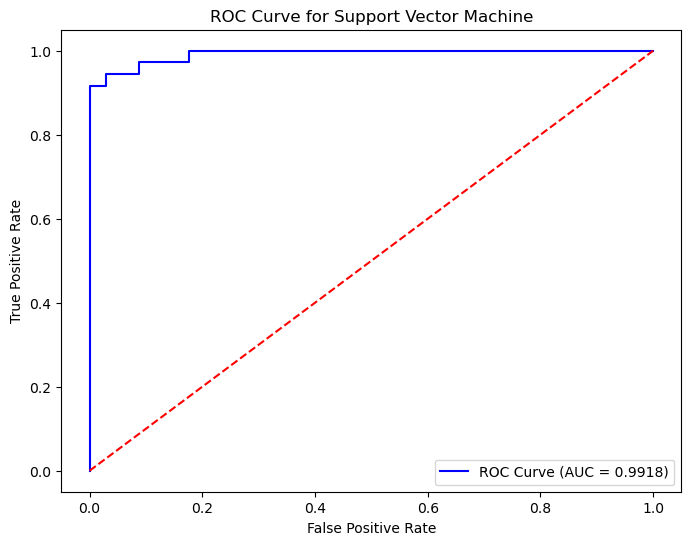

In [20]:
# Initialize the Support Vector Machine model
svc_model = SVC(kernel='linear', random_state=123, probability=True)

# Train the model
svc_model.fit(X_train, y_train)

# Predict on the training data
svc_y_train_pred = svc_model.predict(X_train)

# Predict on the test data
svc_y_test_pred = svc_model.predict(X_test)

# Calculate accuracy for training and test data
svc_train_accuracy = accuracy_score(y_train, svc_y_train_pred)
svc_test_accuracy = accuracy_score(y_test, svc_y_test_pred)

print(f"Support Vector Machine Training Accuracy: {svc_train_accuracy:.4f}")
print(f"Support Vector Machine Test Accuracy: {svc_test_accuracy:.4f}")

# Calculate overfitting
svc_overfitting = svc_train_accuracy - svc_test_accuracy
print(f"Support Vector Machine Overfitting (Training - Test): {svc_overfitting:.4f}")

# Classification report
print("Classification Report for Support Vector Machine:")
print(classification_report(y_test, svc_y_test_pred))

# Confusion Matrix
svc_cm = confusion_matrix(y_test, svc_y_test_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
svc_y_test_pred_proba = svc_model.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_y_test_pred_proba)
roc_auc_svc = roc_auc_score(y_test, svc_y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', label=f'ROC Curve (AUC = {roc_auc_svc:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vector Machine')
plt.legend()
plt.show()


#### Model 3. Extreme Gradient Boosting (XGBoost) Model

XGBoost Training Accuracy: 1.0000
XGBoost Test Accuracy: 0.9714
XGBoost Overfitting (Training - Test): 0.0286
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.97      0.97      0.97        36

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70



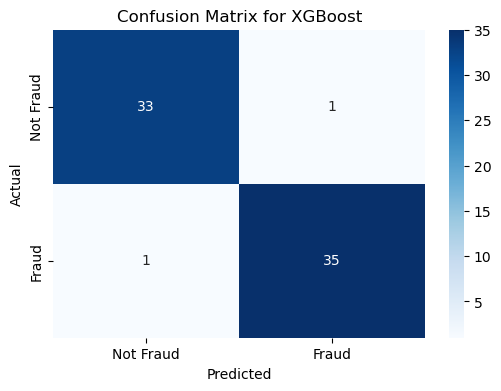

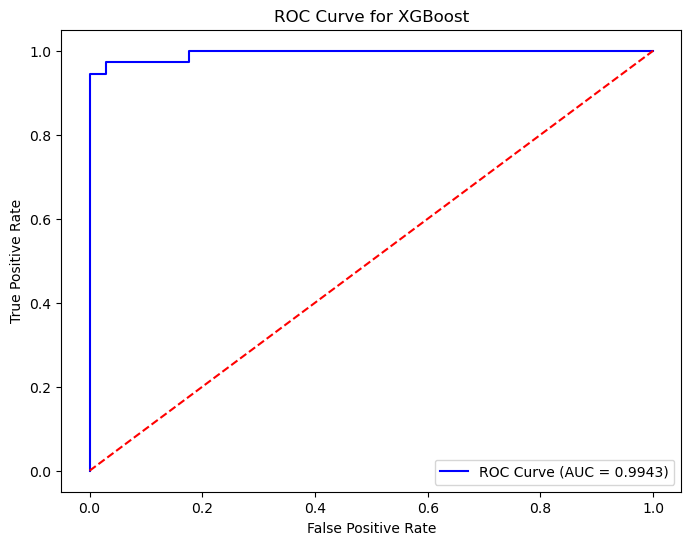

In [21]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=123)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the training data
xgb_y_train_pred = xgb_model.predict(X_train)

# Predict on the test data
xgb_y_test_pred = xgb_model.predict(X_test)

# Calculate accuracy for training and test data
xgb_train_accuracy = accuracy_score(y_train, xgb_y_train_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_y_test_pred)

print(f"XGBoost Training Accuracy: {xgb_train_accuracy:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# Calculate overfitting
xgb_overfitting = xgb_train_accuracy - xgb_test_accuracy
print(f"XGBoost Overfitting (Training - Test): {xgb_overfitting:.4f}")

# Classification report
print("Classification Report for XGBoost:")
print(classification_report(y_test, xgb_y_test_pred))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_y_test_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
xgb_y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_y_test_pred_proba)
roc_auc_xgb = roc_auc_score(y_test, xgb_y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'ROC Curve (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()


#### Model comparison 

In [22]:
# calculated model results and overfitting values
logreg_train_accuracy = 0.9753
logreg_test_accuracy = 0.9571  
logreg_overfitting = logreg_train_accuracy - logreg_test_accuracy

svc_train_accuracy = 0.9753 
svc_test_accuracy = 0.9571 
svc_overfitting = svc_train_accuracy - svc_test_accuracy

xgb_train_accuracy = 1.0000     
xgb_test_accuracy = 0.9714      
xgb_overfitting = xgb_train_accuracy - xgb_test_accuracy

# Create a DataFrame to summarize the results
results = {
    "Model": ["Logistic Regression", "Support Vector Machine", "XGBoost"],
    "Training Accuracy": [logreg_train_accuracy, svc_train_accuracy, xgb_train_accuracy],
    "Test Accuracy": [logreg_test_accuracy, svc_test_accuracy, xgb_test_accuracy],
    "Overfitting (Train - Test)": [logreg_overfitting, svc_overfitting, xgb_overfitting]
}

results_df = pd.DataFrame(results)

# Display the DataFrame to confirm
print(results_df)


                    Model  Training Accuracy  Test Accuracy  \
0     Logistic Regression             0.9753         0.9571   
1  Support Vector Machine             0.9753         0.9571   
2                 XGBoost             1.0000         0.9714   

   Overfitting (Train - Test)  
0                      0.0182  
1                      0.0182  
2                      0.0286  


### Plot the Overfitting Analysis

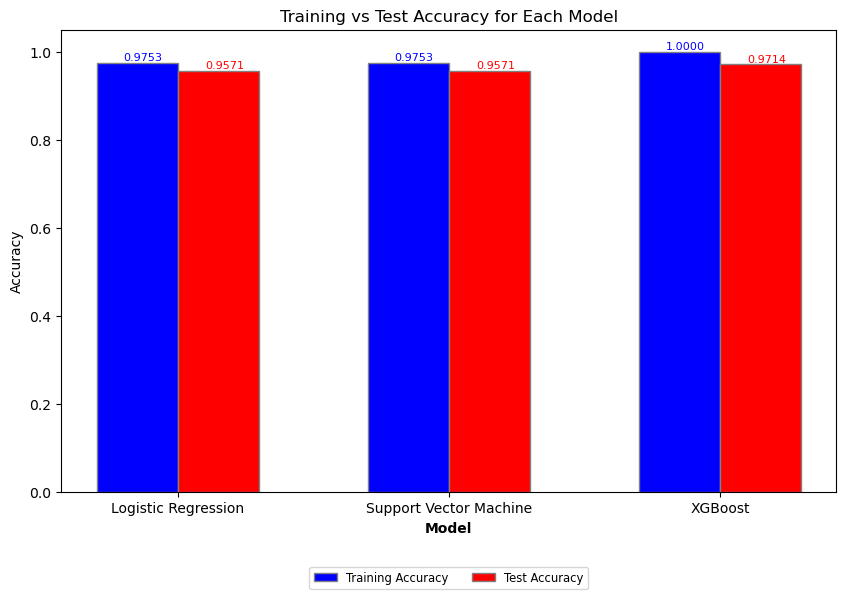

In [23]:
# Define the bar width
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(results_df['Model']))
r2 = [x + bar_width for x in r1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting the bars
plt.bar(r1, results_df['Training Accuracy'], color='b', width=bar_width, edgecolor='grey', label='Training Accuracy')
plt.bar(r2, results_df['Test Accuracy'], color='r', width=bar_width, edgecolor='grey', label='Test Accuracy')

# Adding labels for each bar with adjusted position and smaller font size
for i in range(len(results_df['Model'])):
    plt.text(r1[i] - 0.05, results_df['Training Accuracy'][i] + 0.005, f"{results_df['Training Accuracy'][i]:.4f}", color='b', fontsize=8)
    plt.text(r2[i] - 0.05, results_df['Test Accuracy'][i] + 0.005, f"{results_df['Test Accuracy'][i]:.4f}", color='r', fontsize=8)

# Customizing the plot
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(results_df['Model']))], results_df['Model'])
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy for Each Model')

# Adjusting legend position and font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize='small')  # Moves legend further below the plot

# Display the plot
plt.show()


<a id='Conclusion'></a>
#### 6. Conclusion

Logistic Regression and SVM models show similar performance with high training and test accuracies and low overfitting values. This suggests that both models are robust and generalize well to new data.
XGBoost achieves perfect accuracy on the training data but shows slightly higher overfitting compared to the other two models. While it still performs well on the test data, this indicates that the model may be too complex.
In summary, all models perform well, but Logistic Regression and SVM provide a better balance between training and test performance with minimal overfitting. XGBoost, while powerful, shows a tendency to overfit slightly more.

#### Saving model as a pickle file
Despite XGBoost slightly overfit, its still a good more to create fraud prediction prototye which will be dine in another python file called 'fraud_detection_app.py'.

In [31]:
import os
import pickle

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model as a pickle file
filename = 'models/xgboost_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgb_model, file)

print(f"Model saved to {filename}")


Model saved to models/xgboost_model.pkl
